In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd


# Reproducibility so the results stay the same every time note book is ran
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed(420)

2022-09-16 12:36:45.534544: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-16 12:36:45.534596: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Loading and labeling training dataset
train_ = image_dataset_from_directory(
    './images/train',
    labels='inferred',
    label_mode='binary',
    image_size=[299, 299],
    interpolation='nearest',
    batch_size=64,
    shuffle=True
)

# Loading and labeling testing dataset
test_ = image_dataset_from_directory(
    './images/test',
    labels='inferred',
    label_mode='binary',
    image_size=[299, 299],
    interpolation='nearest',
    batch_size=64,
    shuffle=True
)

# Plots 20 random images from the dataset
def plot_random_images(classtype):
    plt.figure(figsize=(10, 10))
    class_names = classtype.class_names
    for images, labels in classtype:
        for i in range(32):
            ax = plt.subplot(6, 6, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i])] + f'{labels[i]}')
            plt.axis("off")

Found 4466 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


2022-09-16 12:36:49.055373: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-16 12:36:49.055416: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-16 12:36:49.055445: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (olli-UX430UNR): /proc/driver/nvidia/version does not exist
2022-09-16 12:36:49.057210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


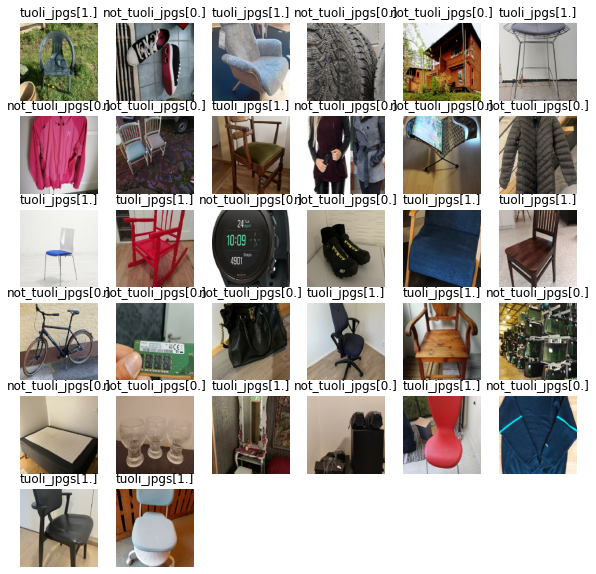

In [3]:
plot_random_images(train_)

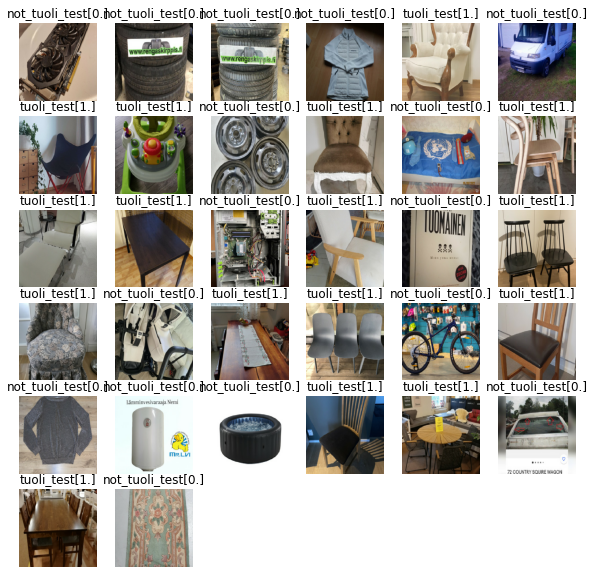

In [4]:
plot_random_images(test_)

In [5]:
# Preprocessing images for the model
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
train = train_.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)
test = test_.map(convert_to_float).cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
# Loading a pretrained base i.e. a model that Pytorch Team has made
pretrained_base = tf.keras.applications.InceptionV3(include_top=True)
pretrained_base.trainable = False

In [7]:
# Building a model on top of the pretrained base
model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [8]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

# Training the model
history = model.fit(train, validation_data=test, epochs=5)

Epoch 1/5


2022-09-16 12:37:31.088581: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 181870592 exceeds 10% of free system memory.
2022-09-16 12:37:31.379230: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 177020928 exceeds 10% of free system memory.
2022-09-16 12:37:31.586338: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 354041856 exceeds 10% of free system memory.
2022-09-16 12:37:32.064905: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 247775232 exceeds 10% of free system memory.


 1/70 [..............................] - ETA: 10:26 - loss: 0.6926 - binary_accuracy: 0.5156

2022-09-16 12:37:35.370572: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 181870592 exceeds 10% of free system memory.


57/70 [=======================>......] - ETA: 53s - loss: 0.6802 - binary_accuracy: 0.6475

KeyboardInterrupt: 

In [ ]:
import seaborn as sns

# Plotting the loss, more info on loss: 
# https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/
plt.figure(figsize=(14, 6))
sns.lineplot(data=(history.history['loss'], history.history['val_loss']))
plt.ylabel('loss')
plt.xlabel('epoch')

In [ ]:
# Plotting the accuracy of the model's predictions
plt.figure(figsize=(14, 6))
sns.lineplot(data=(history.history['binary_accuracy'], history.history['val_binary_accuracy']))
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [ ]:
import pickle

# Saving the trained model
filename = 'tori_classifier_model.sav'
pickle.dump(model, open(filename, 'wb'))